
[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


작업 폴더: /Users/serinoh/SAPA


점수 데이터: 23,647명
State 정보 병합 후: 23,647명
State 결측: 0명


=== State별 표본 수 ===
state
other           16339
California       1713
Michigan          860
Illinois          820
Texas             711
Pennsylvania      700
Florida           696
New York          684
Washington        599
Virginia          525
Name: count, dtype: int64


분석 대상 State 수: 9
분석 대상: ['California', 'Michigan', 'Illinois', 'Texas', 'Pennsylvania', 'Florida', 'New York', 'Washington', 'Virginia']

분석 대상 응답자 수: 7,308명


In [12]:
# 분석할 7개 척도 (실제 컬럼명 사용)
scales = ['NEO_O', 'NEO_C', 'NEO_E', 'NEO_A', 'NEO_N', 'Ideology', 'Honesty_Humility']
scale_labels = ['O', 'C', 'E', 'A', 'N', 'Ideology', 'H-H']

# 전체 평균 (Grand Mean)
grand_means = df_analysis[scales].mean()
print('=== Grand Mean (전체 평균) ===')
for scale, label in zip(scales, scale_labels):
    print(f'{label:10s}: {grand_means[scale]:.3f}')

=== Grand Mean (전체 평균) ===
O         : 4.275
C         : 4.294
E         : 3.953
A         : 4.290
N         : 3.321
Ideology  : 0.087
H-H       : 0.067


기술통계 계산 완료: 63행


=== Critical Ratios 계산 완료 ===
        State     Scale     N      Mean        SE  Grand_Mean        CR  \
0  California         O  1700  4.300743  0.019387    4.275382  1.308138   
1  California         C  1698  4.247318  0.020426    4.294258 -2.298020   
2  California         E  1693  3.897793  0.021492    3.953343 -2.584626   
3  California         A  1692  4.262027  0.018585    4.290150 -1.513200   
4  California         N  1693  3.321658  0.022975    3.321213  0.019380   
5  California  Ideology   836 -0.016157  0.033218    0.086998 -3.105370   
6  California       H-H   959 -0.006407  0.022875    0.067181 -3.217012   
7    Michigan         O   850  4.185835  0.027825    4.275382 -3.218221   
8    Michigan         C   854  4.367139  0.027546    4.294258  2.645837   
9    Michigan         E   852  3.936985  0.030986    3.953343 -0.527900   

   Significant Direction  
0        False         ↑  
1        False         ↓  
2        False         ↓  
3        False         ↓  
4        

=== 유의미한 특징 (|CR| > 3.0) ===
총 8개

Michigan        H-H        CR= +4.32 ↑
New York        O          CR= +3.87 ↑
Illinois        E          CR= +3.65 ↑
Michigan        A          CR= +3.34 ↑
Florida         N          CR= -3.22 ↓
Michigan        O          CR= -3.22 ↓
California      H-H        CR= -3.22 ↓
California      Ideology   CR= -3.11 ↓


/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/3993554040.py:26: UserWarning: Glyph 52377 (\N{HANGUL SYLLABLE CEOG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/3993554040.py:26: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/3993554040.py:26: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/3993554040.py:26: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/3993554040.py:26: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/3993554040.py:26: Us

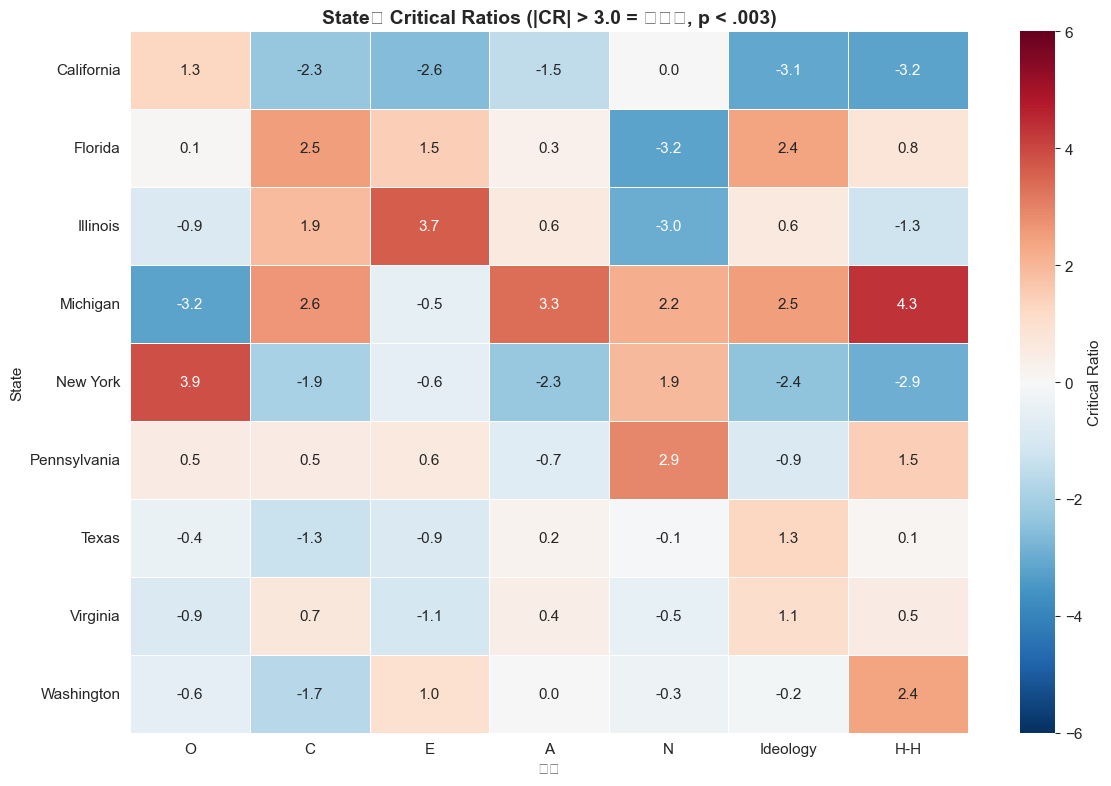


✅ 저장 완료: reports/figures/state_critical_ratios_heatmap.png


/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/1527587494.py:14: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/1527587494.py:14: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/1527587494.py:14: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/1527587494.py:14: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/1527587494.py:14: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/80/n1ysq5hd7rn7k069cjk7z9fc0000gn/T/ipykernel_44729/1527587494.py:14: Us

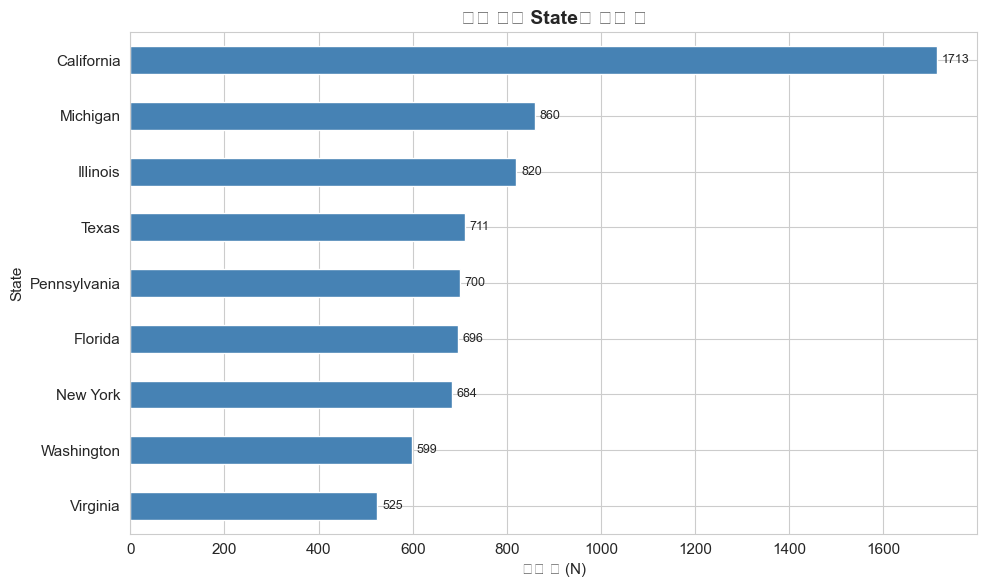


총 분석 대상 State: 9개
총 분석 대상 응답자: 7,308명


=== State Analysis 요약 ===

분석 대상:
  - State 수: 9개
  - 응답자 수: 7,308명
  - 분석 척도: 7개

유의미한 특징 (|CR| > 3.0):
  - 총 8개

State별 유의미 특징 수:
  - Michigan: 3개
  - California: 2개
  - Florida: 1개
  - Illinois: 1개
  - New York: 1개

생성된 파일:
  - reports/figures/state_critical_ratios_heatmap.png
